Solving a polar Laplace Equation (with a sin drichlet boundry condition):

In [10]:
import tensorflow as tf
import numpy as np

DTYPE='float32' 
tf.keras.backend.set_floatx(DTYPE)

pi = tf.constant(np.pi, dtype=DTYPE) 
# Defining boundry:
def boundryfun(phi):
  return  tf.sin(10*phi) #tf.sin(3*phi)#tf.sin(6*pi*y) 

def residual(r, phi, z, z_r, z_p, z_rr, z_pp):
  return (z_rr + (1/r)*(z_r) + (1/r**2)*(z_pp))

# Setting Data points:
N_b = 1000     
N_r = 5000

# Setting Boundry:    
rmin = 0.1
rmax = 1.0
phimin = 0.0
phimax =  2*3.14159265358979323846

lb = tf.constant([rmin, phimin], dtype = DTYPE)
ub = tf.constant([rmax, phimax], dtype = DTYPE)

tf.random.set_seed(0) 
# Boundry Value data
r_b = tf.ones((N_b, 1), dtype = DTYPE)*ub[0]
phi_b = tf.random.uniform((N_b, 1), lb[1], ub[1], dtype = DTYPE)  
R_b = tf.concat([phi_b, r_b], axis = 1)
z_b = boundryfun(phi_b)                      

# Residual Points (Coallocation Points)
r_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)   
phi_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
R_r = tf.concat([phi_r, r_r], axis = 1)

# Net data
R_data = [R_b]
Z_data = [z_b]

[Text(0.5, 0, '$y$'), Text(0.5, 0, '$x$')]

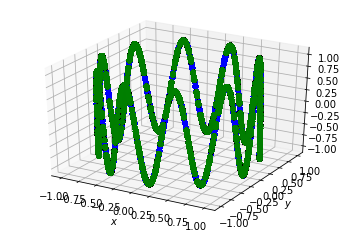

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection = '3d')
radius, theta = np.meshgrid(r_b, phi_b)
X = radius*np.sin(theta)
Y = radius*np.cos(theta)

# Z = np.ones((N_b, N_b))
# def plott(radius, theta):
#   for i in 
Z = boundryfun(theta)

ax.scatter3D(X, Y, Z, color = 'green')
# ax.scatter3D(x_b1, y_b1, z_b1, color = 'green')
# ax.scatter3D(x_b2, y_b2, z_b2, color = 'green')
# ax.scatter3D(x_b3, y_b3, z_b3, color = 'blue')

N = 600
rsp = np.ones(N)
phisp= np.linspace(lb[1], ub[1] , N )
radiu, thet = np.meshgrid(rsp, phisp)
Xb = radiu*np.sin(thet)
Yb = radiu*np.cos(thet)

Zb = boundryfun(thet)
ax.scatter3D(Xb, Yb, Zb, color = 'blue')

ax.set(xlabel = '$x$', ylabel ='$y$')




In [3]:
print(boundryfun(0.0))

1


In [12]:
def init_model(num_hidden_layers=10, num_neurons_per_layer=25):
    model = tf.keras.Sequential() 
    model.add(tf.keras.Input(2))  
    scaling_layer = tf.keras.layers.Lambda(lambda x: 2.0*(x - lb)/(ub - lb) - 1.0) 
    model.add(scaling_layer)  
    for i in range(num_hidden_layers):     
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,activation=tf.keras.activations.get('tanh'),
                                        kernel_initializer='glorot_normal'))  #

    model.add(tf.keras.layers.Dense(1))   
    return model

In [5]:
def get_residual(model, R_r):

  with tf.GradientTape(persistent = True) as tape:
    phi, r = R_r[:, 0:1], R_r[:,1:2] 
    tape.watch(phi)
    tape.watch(r)

    z = model(tf.stack([phi[:,0], r[:,0]], axis=1)) 
    z_r = tape.gradient(z, r)    
    z_p = tape.gradient(z, phi)

  z_pp = tape.gradient(z_p, phi)
  z_rr = tape.gradient(z_r, r)

  del tape

  return residual(r, phi, z, z_r, z_p, z_rr, z_pp)

##################################### Calculating the loss function:

def compute_loss(model, R_r, R_data, Z_data, lmbd = 10**-5):

  loss = 0
  r = get_residual(model, R_r)          
  rloss = tf.reduce_mean(tf.square(r))  

  loss += lmbd*(rloss)
  for i in range(len(R_data)):
      Z_pred = model(R_data[i])   
      loss += tf.reduce_mean(tf.square(Z_data[i] - Z_pred))
    
  return loss

########################################### Getting gradients
def get_grad(model, R_r, R_data, Z_data):
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, R_r, R_data, Z_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [13]:
########################################### Initialising the model
model = init_model()
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
optim = tf.keras.optimizers.Adam(learning_rate=lr)

########################################### Training the model
from time import time

@tf.function
def train_step():
    loss, grad_theta = get_grad(model, R_r, R_data, Z_data)
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    return loss

# Number of training epochs
N = 10000
hist = []

# Start timer
t0 = time()
for i in range(N+1):
    loss = train_step()
    hist.append(loss.numpy())
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
print('\nComputation time: {} seconds'.format(time()-t0))
###########################################

It 00000: loss = 5.68147004e-01
It 00050: loss = 4.92930412e-01
It 00100: loss = 4.84379232e-01
It 00150: loss = 4.58213776e-01
It 00200: loss = 4.25715178e-01
It 00250: loss = 4.24930423e-01
It 00300: loss = 3.94768685e-01
It 00350: loss = 3.93494815e-01
It 00400: loss = 3.89190763e-01
It 00450: loss = 3.60949188e-01
It 00500: loss = 3.85329694e-01
It 00550: loss = 3.48139763e-01
It 00600: loss = 3.39112490e-01
It 00650: loss = 3.46308410e-01
It 00700: loss = 3.26517820e-01
It 00750: loss = 3.32773566e-01
It 00800: loss = 3.30471635e-01
It 00850: loss = 3.15132409e-01
It 00900: loss = 3.24871510e-01
It 00950: loss = 3.22135508e-01
It 01000: loss = 3.10876817e-01
It 01050: loss = 2.98737407e-01
It 01100: loss = 2.86833376e-01
It 01150: loss = 2.84458458e-01
It 01200: loss = 2.83140242e-01
It 01250: loss = 2.81714201e-01
It 01300: loss = 2.77184129e-01
It 01350: loss = 2.60894954e-01
It 01400: loss = 2.55841553e-01
It 01450: loss = 2.52472222e-01
It 01500: loss = 2.46327639e-01
It 01550

The plot of the wave equation


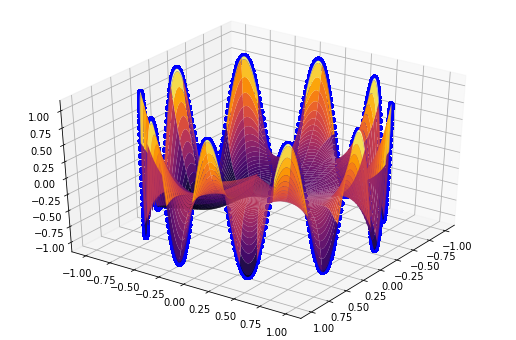

In [14]:
print("The plot of the wave equation")


# Set up meshgrid
N = 600
rspace = np.linspace(lb[0], ub[0] , N + 1)
phispace = np.linspace(lb[1], ub[1] , N + 1)
R, P = np.meshgrid(rspace, phispace)
tspace = np.ones((N+1)*(N+1))*40.0
#X, Y = np.meshgrid(yspace, xspace)
Xgrid = np.vstack([P.flatten(),R.flatten()]).T  # What is vstack and flatten
zpred = model(tf.cast(Xgrid,DTYPE)) 

Z = zpred.numpy().reshape(N+1,N+1)

X, Y = R*np.cos(P), R*np.sin(P)
# Plotting
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='inferno');

# Plotting Boundry
N = 600
rsp = np.ones(N)
phisp= np.linspace(lb[1], ub[1] , N )
radiu, thet = np.meshgrid(rsp, phisp)
Xb = radiu*np.sin(thet)
Yb = radiu*np.cos(thet)

Zb = boundryfun(thet)
ax.scatter3D(Xb, Yb, Zb, color = 'blue')

ax.view_init(35,35)


# ax.scatter3D(y_b, x_b, z_b, color = 'blue')
# ax.scatter3D(y_b1, x_b1, z_b1, color = 'green')